In [1]:
import re

import numpy as np
import pandas as pd

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from baseline.config import STOP_WORDS

In [2]:
# Load PR Newswire Annotated Dataset
pr_newswire = pd.read_csv("../data/pr-newswire.csv")

In [3]:
def text_cleaning(text: str):
    """Cleans raw text input for Doc2Vec."""
    ps = PorterStemmer()
    
    # Strip punctuation and special chars
    stripped = re.sub(r"[^\w]", " ", text)
    
    # Tokenize and stem words
    tokenized = [
        ps.stem(token.lower()) for token in stripped.split(" ")
        if token.strip() and token.lower() not in STOP_WORDS
    ]
    
    return tokenized

In [4]:
raw_news_stories = pr_newswire["data"]

# Establish data and target for vectorization
stories = list(map(text_cleaning, raw_news_stories))
classifications = list(pr_newswire["target"])

In [5]:
# Build Doc2Vec `TaggedDocument` array
documents = [
    TaggedDocument(story, classifications[idx]) for idx, story in enumerate(stories)
]

In [6]:
# Build Doc2Vec model
d2v = Doc2Vec(vector_size=40, min_count=2, epochs=30)
# Build vocabulary
d2v.build_vocab(documents)

In [7]:
# Train doc2vec
d2v.train(documents, total_examples=d2v.corpus_count, epochs=d2v.epochs)

In [8]:
# Destructure words and tags from TaggedDocument
words = [doc.words for doc in documents]
tags = [doc.tags for doc in documents]

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(words, tags, test_size=0.20)

In [9]:
# Build vectors for training
x_train_vectors = [
    d2v.infer_vector(instance) for instance in x_train
]

# Build LabelEncoder for training
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Encode training lables
y_train_labels = label_encoder.transform(np.asarray(y_train))

In [10]:
# Fit Logistic Regression on infered vectors
logreg = LogisticRegression(max_iter=1000, multi_class="multinomial")
logreg.fit(x_train_vectors, y_train_labels)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [11]:
# Build vectors for testing
x_test_vectors = [
    d2v.infer_vector(instance) for instance in x_test
]

In [12]:
# Predictions
y_pred = logreg.predict(x_test_vectors)

In [13]:
# Encode test lables
y_test_labels = label_encoder.transform(y_test)

In [14]:
print(f"Classes: {logreg.classes_}")
print(f"Intercepts: {logreg.intercept_}")
print(f"Coefficient: {logreg.coef_}")

Classes: [0 1 2 3 4]
Intercepts: [-1.99210594  4.87528518 -2.75704769 -2.62819345  2.5020619 ]
Coefficient: [[ 0.16013212 -0.31449612 -0.26074251 -0.03450813  0.07844036  0.36600841
   0.25971519 -0.0868849  -0.20685688  0.01995699 -0.12485248 -0.07522143
   0.15833307 -0.10621958 -0.07192843 -0.21167597 -0.03588129 -0.09021465
  -0.04019817  0.10800007  0.22516089  0.13557395 -0.06066661 -0.07713291
   0.07125189 -0.12996687  0.25346397  0.07515894  0.05762258  0.04034921
  -0.025812    0.20314085  0.08039424  0.07979124  0.06822696 -0.13963074
  -0.0289924   0.02739583  0.05243132  0.21117173]
 [-0.18864466  0.17134938 -0.19297969 -0.17474552  0.21272013  0.12033655
  -0.44884504  0.15800548  0.13684706 -0.08377268 -0.1320503   0.1444602
  -0.24909307 -0.13036052 -0.10659114  0.03941235 -0.1057303  -0.12318781
  -0.30172713 -0.39059299  0.10516836 -0.44700529  0.11740508  0.24250145
  -0.27525872 -0.19850613 -0.34967104  0.27069601  0.10576039 -0.08333278
   0.12250096  0.08865317  0

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
)

In [16]:
c_matrix = confusion_matrix(y_test_labels, logreg.predict(x_test_vectors))

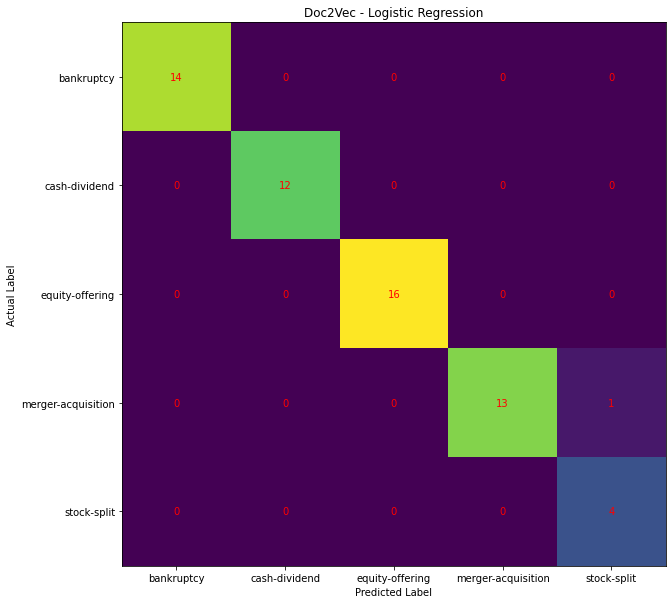

In [17]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(c_matrix)

ax.set_ylabel("Actual Label")
ax.set_xlabel("Predicted Label")
labels = tuple(label_encoder.inverse_transform([0, 1, 2, 3, 4]))
ax.xaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=labels)
ax.yaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=labels)
plt.title("Doc2Vec - Logistic Regression")
for i in range(len(labels)):  # ref: (https://realpython.com/logistic-regression-python/)
    for j in range(len(labels)):
        ax.text(j, i, c_matrix[i, j], ha='center', va='center', color='red')
plt.savefig("doc2vec-logistic-regression")

In [18]:
# Calculate key metrics
precision = precision_score(y_test_labels, y_pred, average="weighted")
recall = recall_score(y_test_labels, y_pred, average="weighted")
f1 = f1_score(y_test_labels, y_pred, average="weighted")

print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"F1 Score: {f1}")

Precision Score: 0.9866666666666667
Recall Score: 0.9833333333333333
F1 Score: 0.9839506172839506


In [19]:
# Classification Report
print(classification_report(y_test, label_encoder.inverse_transform(y_pred)))

                    precision    recall  f1-score   support

        bankruptcy       1.00      1.00      1.00        14
     cash-dividend       1.00      1.00      1.00        12
   equity-offering       1.00      1.00      1.00        16
merger-acquisition       1.00      0.93      0.96        14
       stock-split       0.80      1.00      0.89         4

          accuracy                           0.98        60
         macro avg       0.96      0.99      0.97        60
      weighted avg       0.99      0.98      0.98        60



In [20]:
from sklearn.decomposition import TruncatedSVD

In [21]:
# Decompose sparse matrix
tsvd = TruncatedSVD()
x_decomposed = tsvd.fit_transform(x_train_vectors)

# Make dimensions
x = x_decomposed[:, 0]
y = x_decomposed[:, 1]

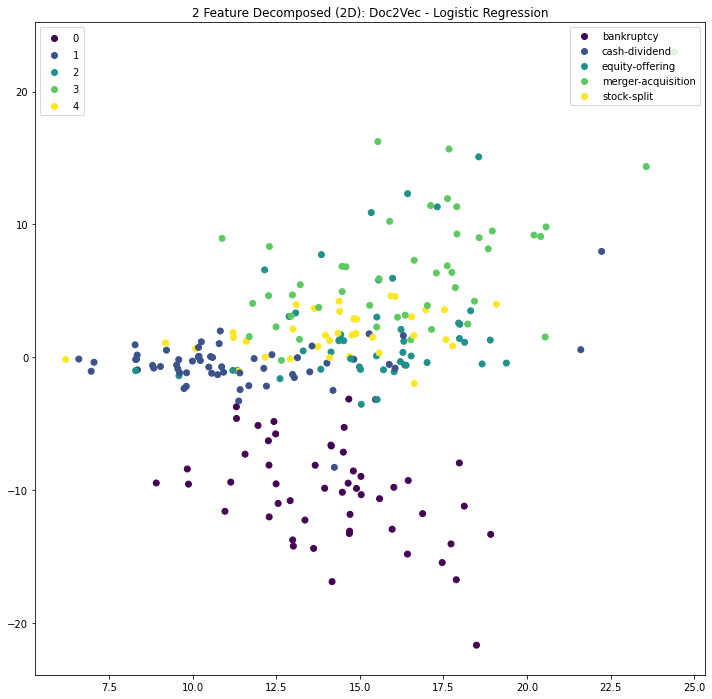

In [22]:
# 2D Plot
fig2d = plt.figure(figsize=(12, 12))

ax = plt.axes()
scatter = plt.scatter(x, y, c=label_encoder.transform(y_train))

# Build Legend
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
handles, labels = scatter.legend_elements()
ax.legend(
    handles,
    label_encoder.inverse_transform([int(as_int[-3]) for as_int in labels]),
    loc=1
)

# Show Plot
plt.title("2 Feature Decomposed (2D): Doc2Vec - Logistic Regression")
plt.show()
fig2d.savefig("doc2vec-logistic-regression-2d-scatter")

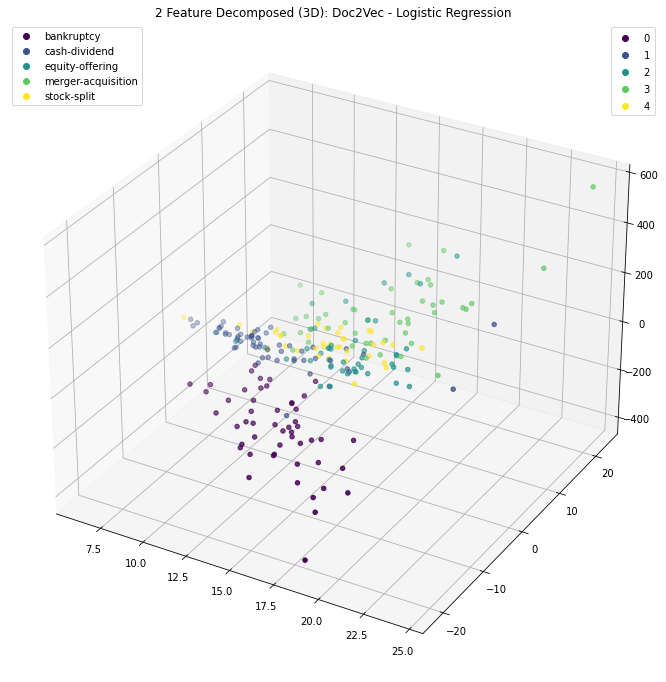

In [23]:
# Make 3 dimensions
x = x_decomposed[:, 0]
y = x_decomposed[:, 1]
z = x**1 * y**1

# 3D Plot
fig3d = plt.figure(figsize=(12, 12))

ax = plt.axes(projection ="3d")
ax.view_init(1)
ax.scatter3D(x, y, z, c=label_encoder.transform(y_train))

# Build Legend
legend_elements = ax.legend(*scatter.legend_elements())
ax.add_artist(legend_elements)
handles, labels = scatter.legend_elements()
ax.legend(
    handles,
    label_encoder.inverse_transform([int(as_int[-3]) for as_int in labels]),
    loc=2
)
ax.view_init(30)

# Show Plot
plt.title("2 Feature Decomposed (3D): Doc2Vec - Logistic Regression")
plt.show()
fig3d.savefig("doc2vec-logistic-regression-3d-scatter")